<a href="https://colab.research.google.com/github/AtrCheema/AI4Water/blob/dev/examples/paper/customizing_training_loop.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This file describes the minimal example of customizing the whole training function `fit`
using AI4Water's `Model` class.

In [2]:
try:
    import AI4Water
except ImportError:
    !python -m pip install "AI4Water[all] @ git+https://github.com/AtrCheema/AI4Water.git"

ERROR! Session/line number was not unique in database. History logging moved to new session 24888


In [3]:
import tensorflow as tf

tf.__version__

'2.1.0'

In [4]:
from ai4water import Model
from ai4water.datasets import busan_beach

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


d:\c\anaconda3\envs\tfcpu21_py37\lib\site-packages\tpot\builtins\__init__.py:36: UserWarning: Warning: optional dependency `torch` is not available. - skipping import of NN models.
  warnings.warn("Warning: optional dependency `torch` is not available. - skipping import of NN models.")
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.



**********Pytorch models could not be imported **********



In [5]:

# TODO put code in @tf.function
# TODO write validation code

class CustomModel(Model):

    def fit(self,
            x=None,
            y=None,
            data='training',
            callbacks=None,
            **kwargs):

        self.is_training = True
        # Instantiate an optimizer.
        optimizer = self.get_optimizer()
        # Instantiate a loss function.
        if self.api == 'functional':
            loss_fn = self.loss()
            _model = self._model
        else:
            loss_fn = self.loss
            _model = self

        # Prepare the training dataset.
        batch_size = self.config['batch_size']

        train_x, train_label = self.training_data(x=x,y=y,data=data)

        train_dataset = tf.data.Dataset.from_tensor_slices((train_x, train_label))
        train_dataset = train_dataset.shuffle(buffer_size=1024).batch(batch_size)

        for epoch in range(self.config['epochs']):
            print("\nStart of epoch %d" % (epoch,))

            # Iterate over the batches of the dataset.
            for step, (x_batch_train, full_outputs) in enumerate(train_dataset):

                # Open a GradientTape to record the operations run
                # during the forward pass, which enables autodifferentiation.
                with tf.GradientTape() as tape:

                    # Run the forward pass of the layer.
                    # The operations that the layer applies
                    # to its inputs are going to be recorded
                    # on the GradientTape.
                    mask = tf.greater(tf.reshape(full_outputs, (-1,)), 0.0)  # (batch_size,)
                    y_obj = full_outputs[mask]  # (vals_present, 1)

                    if y_obj.shape[0] < 1:  # no observations present for this batch so skip this
                        continue
                    logits = _model(x_batch_train, training=True)  # Logits for this minibatch

                    logits_obj = logits[mask]
                    # Compute the loss value for this minibatch.
                    loss_value = tf.keras.backend.mean(loss_fn(y_obj, logits_obj))

                # Use the gradient tape to automatically retrieve
                # the gradients of the trainable variables with respect to the loss.
                grads = tape.gradient(loss_value, _model.trainable_weights)

                # grads = [tf.clip_by_norm(g, 1.0) for g in grads]
                grads = [tf.clip_by_value(g, -1.0, 1.0) for g in grads]

                # Run one step of gradient descent by updating
                # the value of the variables to minimize the loss.
                optimizer.apply_gradients(zip(grads, _model.trainable_weights))

                # Log every 200 batches.
                if step % 20 == 0:
                    print(f"Training loss at batch {step} is {loss_value} after seeing {(step + 1) * 64} examples")
        return loss_value


In [6]:
layers = {"LSTM_0": {'units': 64, 'return_sequences': True},
          "LSTM_1": 32,
          "Dropout": 0.3,
          "Dense": 1
          }

In [7]:
beach_data = busan_beach()
input_features = beach_data.columns.tolist()[0:-1]
output_features = beach_data.columns.tolist()[-1:]

model = CustomModel(model={'layers': layers},
                    batch_size=12,
                    ts_args={'lookback':15},
                    lr=8.95e-5,
                    allow_nan_labels=2,
                    epochs=10,
                    input_features=input_features,
                    output_features=output_features,
                    train_data='random'
                    )

building DL model for  regression problem using CustomModel
Model: "custom_model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 15, 13)]          0         
_________________________________________________________________
LSTM_0 (LSTM)                (None, 15, 64)            19968     
_________________________________________________________________
LSTM_1 (LSTM)                (None, 32)                12416     
_________________________________________________________________
Dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
Dense (Dense)                (None, 1)                 33        
_________________________________________________________________
output_reshaped (Reshape)    (None, 1, 1)              0         
Total params: 32,417
Trainable params: 32,417
Non-trainabl

In [8]:
history = model.fit(data=beach_data, callbacks={'tensorboard': True})


********** Allowing NANs in predictions **********

***** Training *****
input_x shape:  (916, 15, 13)
target shape:  (916, 1, 1)

Start of epoch 0
Instructions for updating:
Use tf.identity instead.


Instructions for updating:
Use tf.identity instead.


Training loss at batch 0 is 52657008640.0 after seeing 64 examples
Training loss at batch 20 is 19526180.0 after seeing 1344 examples
Training loss at batch 40 is 12292686086144.0 after seeing 2624 examples
Training loss at batch 60 is 7624766521344.0 after seeing 3904 examples

Start of epoch 1
Training loss at batch 0 is 3780408246272.0 after seeing 64 examples
Training loss at batch 20 is 1.2766266301349888e+16 after seeing 1344 examples
Training loss at batch 40 is 615303232.0 after seeing 2624 examples
Training loss at batch 60 is 12776261025792.0 after seeing 3904 examples

Start of epoch 2
Training loss at batch 0 is 2045319552.0 after seeing 64 examples
Training loss at batch 20 is 74942128128.0 after seeing 1344 examples
Training loss at batch 40 is 2639499886592.0 after seeing 2624 examples
Training loss at batch 60 is 277255641104384.0 after seeing 3904 examples

Start of epoch 3
Training loss at batch 0 is 234561008.0 after seeing 64 examples
Training loss at batch 20 is 12


********** Allowing NANs in predictions **********

***** Test *****
input_x shape:  (287, 15, 13)
target shape:  (287, 1, 1)
assigning name input_1 to IteratorGetNext:0 with shape (None, 15, 13)
287/287 [==============================] - 1s 2ms/sample


d:\c\anaconda3\envs\tfcpu21_py37\lib\site-packages\numpy\lib\nanfunctions.py:1390: RuntimeWarning: All-NaN slice encountered
  overwrite_input, interpolation)


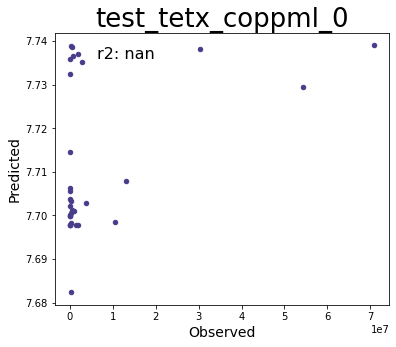

D:\mytools\AI4Water\ai4water\utils\visualizations.py:189: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "." (-> marker='.'). The keyword argument will take precedence.
  axis.plot(true, style, color='b', marker='o', fillstyle='none',  markersize=ms, label='True')


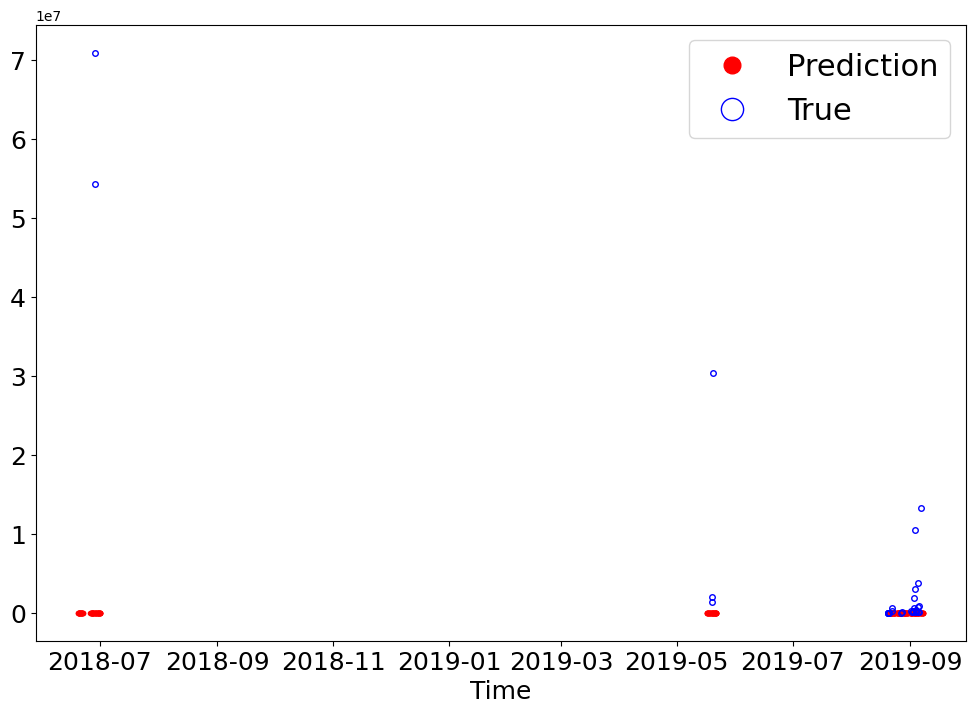

In [9]:
test_pred = model.predict()


********** Allowing NANs in predictions **********

***** Training *****
input_x shape:  (916, 15, 13)
target shape:  (916, 1, 1)
916/916 [==============================] - 0s 162us/sample


d:\c\anaconda3\envs\tfcpu21_py37\lib\site-packages\numpy\lib\nanfunctions.py:1390: RuntimeWarning: All-NaN slice encountered
  overwrite_input, interpolation)


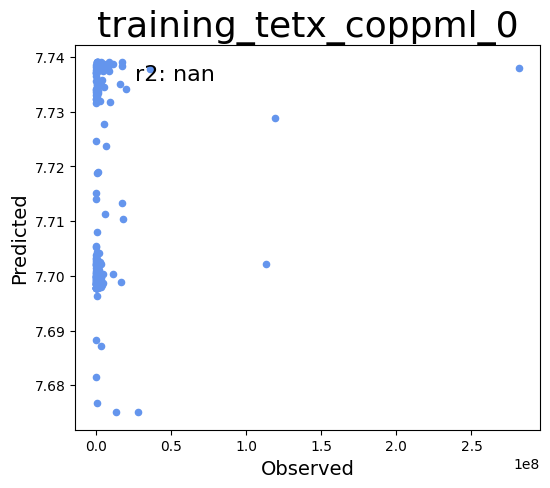

D:\mytools\AI4Water\ai4water\utils\visualizations.py:189: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "." (-> marker='.'). The keyword argument will take precedence.
  axis.plot(true, style, color='b', marker='o', fillstyle='none',  markersize=ms, label='True')


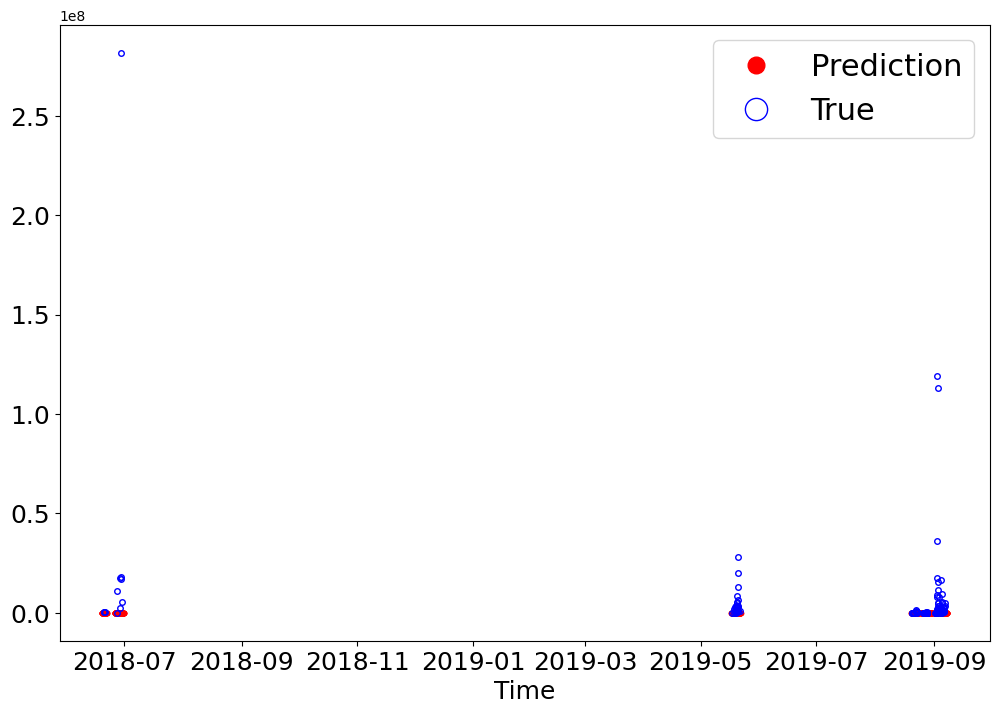

In [10]:
train_pred = model.predict(data='training')